# ***AisleAffinity — Phase 2: Preprocessing & Feature Engineering***


**Dataset:** Instacart Market Basket Analysis (Kaggle: psparks)

This Google Colab notebook is designed to execute the entire preprocessing and feature engineering
pipeline for the Instacart Market Basket Analysis project *from scratch*, meaning it does
not rely on any pre-saved intermediate artifacts. It performs all necessary steps sequentially:

1.  **Data Audit, EDA, and Cleaning:**
    *   Conducts a thorough audit of the raw data, including checks for data types, missing values,
        primary/foreign key integrity, and range validity.
    *   Performs Exploratory Data Analysis (EDA) to uncover key insights, distributions,
        temporal patterns, and co-purchase structures.
    *   Executes data cleaning steps, such as handling duplicates and creating flags (e.g., `is_first_order`),
        and performs necessary table joins to prepare the data for feature engineering.

2.  **Basket Creation:**
    *   Constructs individual purchase "baskets" from the `order_products__prior` dataset,
        ensuring products within each basket are sorted by `add_to_cart_order` and
        meeting a minimum length requirement for meaningful embeddings.

3.  **Product2Vec Training:**
    *   Trains a Word2Vec model using the skip-gram (`sg=1`) architecture to generate
        product embeddings (vector representations).
    *   **Hyperparameters:**
        *   `vector_size=128`: Dimensionality of the product embeddings.
        *   `window=10`: Maximum distance between the current and predicted word within a sentence (basket).
        *   `min_count=15`: Ignores all products with total frequency lower than this.
        *   `epochs=10`: Number of iterations (epochs) over the corpus.
        *   `negative=10`: Number of "noise words" or negative samples to draw.

4.  **Customer Embeddings and Behavioral Features:**
    *   Generates customer-level embeddings by aggregating (e.g., taking the mean) the
        Product2Vec embeddings of all products purchased by each user. This aggregation is
        implemented using a memory-safe, chunked approach suitable for large datasets.
    *   Derives additional "light" behavioral features per user, such as `prior_order_count`,
        `avg_basket_size`, `reorder_ratio`, and `mean_days_between_orders`.

5.  **Holdout Construction:**
    *   Constructs a holdout dataset using each user's "train" order(s) as the ground truth
        for predicting their next basket, crucial for offline model evaluation.

6.  **Optional Visualization and Saves:**
    *   (Optional) Performs 2D dimensionality reduction on customer vectors using UMAP
        to visualize potential customer clusters.
    *   (Optional) Saves all generated artifacts (e.g., cleaned tables, embeddings, holdout set)
        to disk in formats like Parquet or ZIP archives at the very end of the notebook execution.


# ***Config, seeds, and paths***

In [ ]:
# === Config, seeds, and paths ===
import os, random, numpy as np, pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ['PYTHONHASHSEED'] = str(SEED)

# Runtime controls
FAST_MODE = True              # set False to use all users (might OOM on Colab)
NUM_FAST_MODE_USERS = 50_000  # tighten to 30_000 if RAM tight; can raise to 100_000 if OK

# Word2Vec hyperparameters
WORD2VEC_VECTOR_SIZE = 128
WORD2VEC_WINDOW = 10
WORD2VEC_MIN_COUNT = 15
WORD2VEC_EPOCHS = 10

# Optional UMAP params
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 2
UMAP_MIN_DIST = 0.1
UMAP_METRIC = 'cosine'

# Paths
DATA_RAW_DIR = 'data/raw'
PROC_DIR     = 'data/processed'
OUTPUT_DIR   = 'outputs_phase2'
DOCS_DIR     = 'docs'
for d in [DATA_RAW_DIR, PROC_DIR, OUTPUT_DIR, DOCS_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"SEED={SEED}, FAST_MODE={FAST_MODE}, USERS={NUM_FAST_MODE_USERS}")

SEED=42, FAST_MODE=True, USERS=50000


In [ ]:
# === Install libraries ===
!pip -q install -U kaggle gensim umap-learn hdbscan fastparquet pyarrow openpyxl

from gensim.models import Word2Vec
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# **Data extraction**

In [ ]:
# === Kaggle auth and dataset check ===
import os
os.makedirs('/root/.kaggle', exist_ok=True)

from google.colab import files
print("Please upload kaggle.json (from your Kaggle account).")
up = files.upload()
with open('/root/.kaggle/kaggle.json','wb') as f:
    f.write(up['kaggle.json'])
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets files -d psparks/instacart-market-basket-analysis

Please upload kaggle.json (from your Kaggle account).


Saving kaggle.json to kaggle.json
name                            size  creationDate                
-------------------------  ---------  --------------------------  
aisles.csv                      2603  2019-09-21 23:06:09.150000  
departments.csv                  270  2019-09-21 23:06:04.375000  
order_products__prior.csv  577550706  2019-09-21 23:06:20.135000  
order_products__train.csv   24680147  2019-09-21 23:06:12.409000  
orders.csv                 108968645  2019-09-21 23:06:13.057000  
products.csv                 2166953  2019-09-21 23:06:11.233000  


In [ ]:
# === Download and unzip dataset ===
%%bash
set -e
mkdir -p data/raw
echo "Downloading Instacart dataset…"
kaggle datasets download -d psparks/instacart-market-basket-analysis -p data/raw
echo "Unzipping…"
unzip -qo data/raw/*.zip -d data/raw || true
ls -lh data/raw | sed -n '1,60p'

Dataset URL: https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis
License(s): CC0-1.0

Unzipping…
total 878M
-rw-r--r-- 1 root root 2.6K Sep 21  2019 aisles.csv
-rw-r--r-- 1 root root  270 Sep 21  2019 departments.csv
-rw-r--r-- 1 root root 198M Sep 21  2019 instacart-market-basket-analysis.zip
-rw-r--r-- 1 root root 551M Sep 21  2019 order_products__prior.csv
-rw-r--r-- 1 root root  24M Sep 21  2019 order_products__train.csv
-rw-r--r-- 1 root root 104M Sep 21  2019 orders.csv
-rw-r--r-- 1 root root 2.1M Sep 21  2019 products.csv


100%|██████████| 197M/197M [00:00<00:00, 370MB/s]


In [ ]:
# === Load CSVs with dtypes ===
orders_dtypes = {
    'order_id':'int32','user_id':'int32','eval_set':'category','order_number':'int16',
    'order_dow':'int8','order_hour_of_day':'int8','days_since_prior_order':'float32'
}
oprior_dtypes = {'order_id':'int32','product_id':'int32','add_to_cart_order':'int16','reordered':'int8'}
otrain_dtypes = {'order_id':'int32','product_id':'int32','add_to_cart_order':'int16','reordered':'int8'}
prod_dtypes   = {'product_id':'int32','product_name':'string','aisle_id':'int16','department_id':'int16'}
aisle_dtypes  = {'aisle_id':'int16','aisle':'string'}
dept_dtypes   = {'department_id':'int16','department':'string'}

req = ['orders.csv','order_products__prior.csv','order_products__train.csv','products.csv','aisles.csv','departments.csv']
missing = [f for f in req if not os.path.exists(f'{DATA_RAW_DIR}/{f}')]
assert not missing, f"Missing files: {missing}"

orders   = pd.read_csv(f'{DATA_RAW_DIR}/orders.csv', dtype=orders_dtypes)
prior    = pd.read_csv(f'{DATA_RAW_DIR}/order_products__prior.csv', dtype=oprior_dtypes)
train    = pd.read_csv(f'{DATA_RAW_DIR}/order_products__train.csv', dtype=otrain_dtypes)
products = pd.read_csv(f'{DATA_RAW_DIR}/products.csv', dtype=prod_dtypes)
aisles   = pd.read_csv(f'{DATA_RAW_DIR}/aisles.csv', dtype=aisle_dtypes)
depts    = pd.read_csv(f'{DATA_RAW_DIR}/departments.csv', dtype=dept_dtypes)

print("Loaded shapes:", {k:v.shape for k,v in [
    ('orders',orders),('prior',prior),('train',train),('products',products),('aisles',aisles),('depts',depts)]})

Loaded shapes: {'orders': (3421083, 7), 'prior': (32434489, 4), 'train': (1384617, 4), 'products': (49688, 4), 'aisles': (134, 2), 'depts': (21, 2)}


# ***Data audit & availability check***

In [ ]:
# === Audit & integrity checks ===
def audit(df, name, n=10):
    print(f"\n=== Audit: {name} ===")
    print("shape:", df.shape)
    print("dtypes (sample):\n", df.dtypes.head(n))
    print("missing (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))

for name, df in [('orders',orders),('prior',prior),('train',train),('products',products),('aisles',aisles),('depts',depts)]:
    audit(df, name)

report = {}
report['orders.order_id_unique'] = bool(orders['order_id'].is_unique)
report['products.product_id_unique'] = bool(products['product_id'].is_unique)
report['prior_dup_pairs']  = int(prior.duplicated(['order_id','product_id']).sum())
report['train_dup_pairs']  = int(train.duplicated(['order_id','product_id']).sum())
report['prior_missing_order_fk']  = int((~prior['order_id'].isin(orders['order_id'])).sum())
report['prior_missing_product_fk']= int((~prior['product_id'].isin(products['product_id'])).sum())
report['train_missing_order_fk']  = int((~train['order_id'].isin(orders['order_id'])).sum())
report['train_missing_product_fk']= int((~train['product_id'].isin(products['product_id'])).sum())
report['order_dow_out_of_range']  = int((~orders['order_dow'].between(0,6)).sum())
report['order_hour_out_of_range'] = int((~orders['order_hour_of_day'].between(0,23)).sum())

first_order_mask = (orders['order_number'] == 1)
na_mask = orders['days_since_prior_order'].isna()
report['dspo_na_not_first']    = int((na_mask & ~first_order_mask).sum())
report['dspo_non_na_on_first'] = int((~na_mask & first_order_mask).sum())

print("\n=== Audit Summary ===")
for k,v in report.items():
    print(f"{k:32s} -> {v}")


=== Audit: orders ===
shape: (3421083, 7)
dtypes (sample):
 order_id                     int32
user_id                      int32
eval_set                  category
order_number                 int16
order_dow                     int8
order_hour_of_day             int8
days_since_prior_order     float32
dtype: object
missing (top 10):
 days_since_prior_order    206209
user_id                        0
order_id                       0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
dtype: int64

=== Audit: prior ===
shape: (32434489, 4)
dtypes (sample):
 order_id             int32
product_id           int32
add_to_cart_order    int16
reordered             int8
dtype: object
missing (top 10):
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

=== Audit: train ===
shape: (1384617, 4)
dtypes (sample):
 order_id             int32
product_id           in

In [ ]:
# === Required columns presence check ===
required = {
 'orders': ['order_id','user_id','eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order'],
 'prior':  ['order_id','product_id','add_to_cart_order','reordered'],
 'train':  ['order_id','product_id','add_to_cart_order','reordered'],
 'products':['product_id','aisle_id','department_id'],
 'aisles': ['aisle_id','aisle'],
 'depts':  ['department_id','department'],
}
for t, cols in required.items():
    df = globals()[t]
    miss = [c for c in cols if c not in df.columns]
    print(f"{t}: missing -> {miss}")

orders: missing -> []
prior: missing -> []
train: missing -> []
products: missing -> []
aisles: missing -> []
depts: missing -> []


# **EDA:Exploratory data analysis**





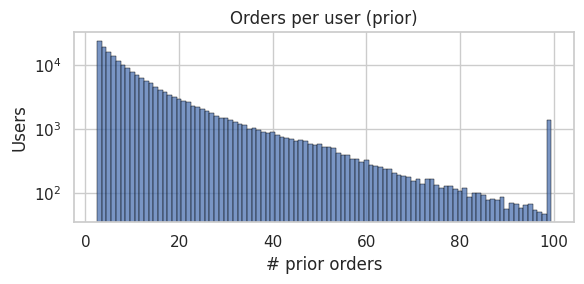

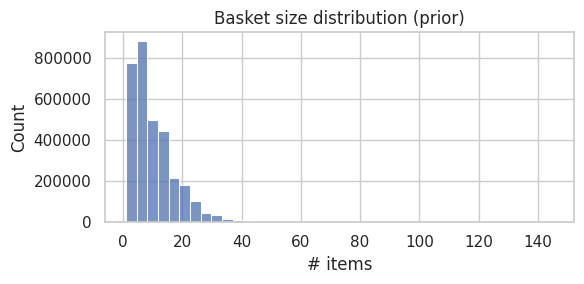

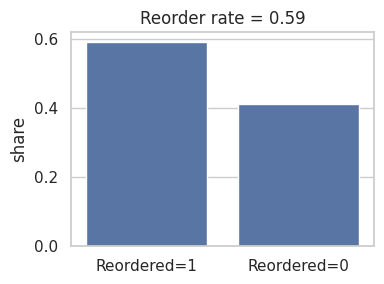

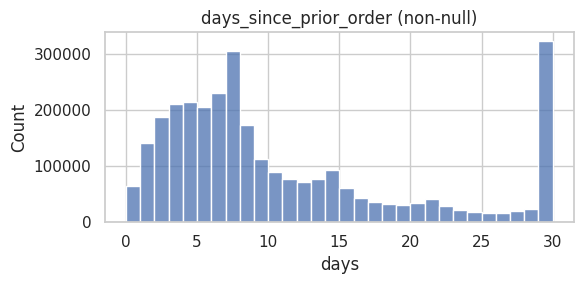

In [ ]:
# === EDA: distributions ===

sns.set(style="whitegrid", font_scale=1.0)

# Orders per user (prior)
orders_per_user = orders[orders.eval_set == 'prior'].groupby('user_id')['order_id'].nunique()

vals = orders_per_user.values
bins = np.arange(vals.min(), vals.max() + 2) - 0.5  # center on integers

plt.figure(figsize=(6,3))
sns.histplot(x=vals, bins=bins, edgecolor='black', color='#4c72b0', stat='count')
plt.yscale('log')  # safer than log_scale tuple
plt.title('Orders per user (prior)')
plt.xlabel('# prior orders'); plt.ylabel('Users')
plt.tight_layout(); plt.show()

# Basket size distribution (prior)
basket_sizes = prior.groupby('order_id')['product_id'].count()
plt.figure(figsize=(6,3)); sns.histplot(basket_sizes, bins=40)
plt.title('Basket size distribution (prior)'); plt.xlabel('# items'); plt.tight_layout(); plt.show()

# Reorder rate
reorder_rate = prior['reordered'].mean()
plt.figure(figsize=(4,3)); sns.barplot(x=['Reordered=1','Reordered=0'], y=[reorder_rate, 1-reorder_rate])
plt.title(f"Reorder rate = {reorder_rate:.2f}"); plt.ylabel('share'); plt.tight_layout(); plt.show()

# Days since prior order (non-null)
dspo = orders[orders.eval_set=='prior']['days_since_prior_order']
plt.figure(figsize=(6,3)); sns.histplot(dspo.dropna(), bins=30)
plt.title('days_since_prior_order (non-null)'); plt.xlabel('days'); plt.tight_layout(); plt.show()

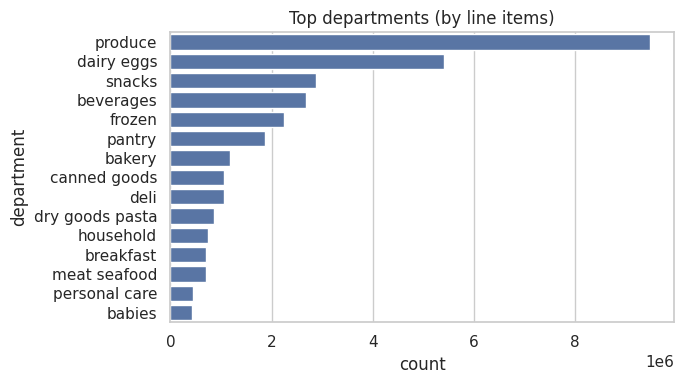

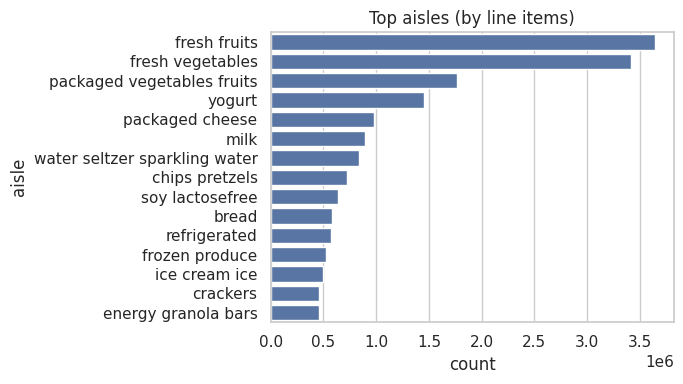

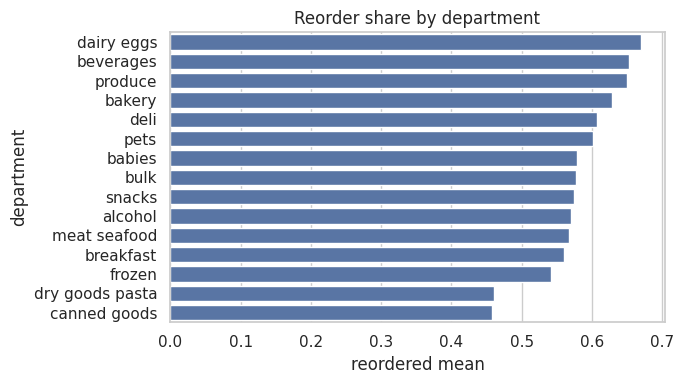

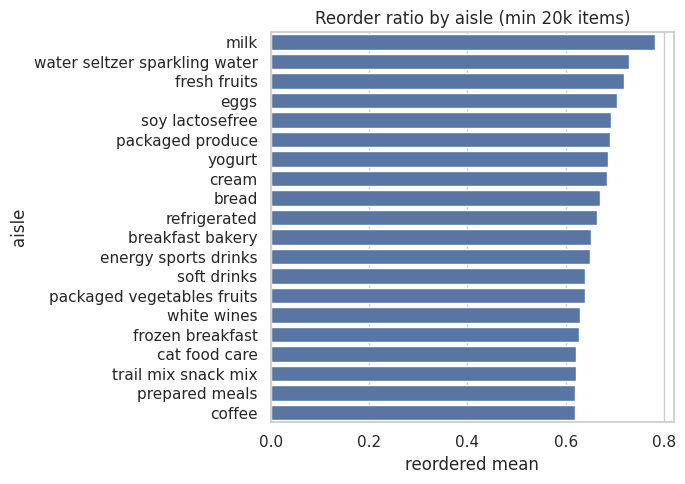

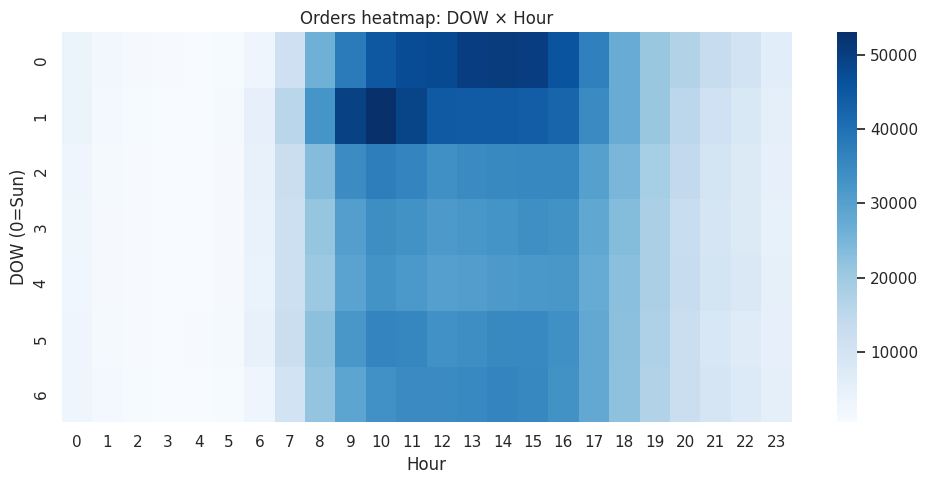

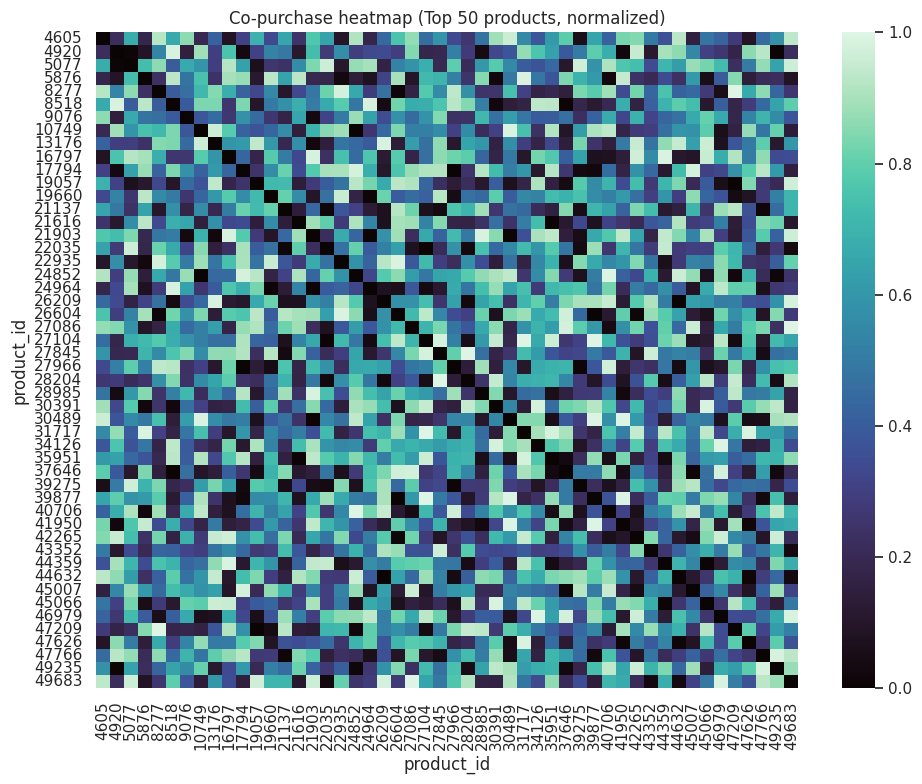

In [ ]:
# === EDA: category joins and visuals ===
prod_cat = (products.merge(aisles, on='aisle_id', how='left')
                    .merge(depts,  on='department_id', how='left'))

orders_min = orders[['order_id','user_id','eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
prior_f = (prior.merge(orders_min, on='order_id', how='left')
                .merge(prod_cat[['product_id','product_name','aisle','department']], on='product_id', how='left'))

# Top departments
dept_counts = prior_f['department'].value_counts().head(15)
plt.figure(figsize=(7,4)); sns.barplot(x=dept_counts.values, y=dept_counts.index)
plt.title('Top departments (by line items)'); plt.xlabel('count'); plt.tight_layout(); plt.show()

# Top aisles
aisle_counts = prior_f['aisle'].value_counts().head(15)
plt.figure(figsize=(7,4)); sns.barplot(x=aisle_counts.values, y=aisle_counts.index)
plt.title('Top aisles (by line items)'); plt.xlabel('count'); plt.tight_layout(); plt.show()

# Reorder ratio by department (top 15)
rr_dept = prior_f.groupby('department')['reordered'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(7,4)); sns.barplot(x=rr_dept.values, y=rr_dept.index)
plt.title('Reorder share by department'); plt.xlabel('reordered mean'); plt.tight_layout(); plt.show()

# Reorder ratio by aisle (min volume threshold)
min_aisle_size = 20_000
aisle_sizes = prior_f['aisle'].value_counts()
top_rr_aisle = (prior_f[prior_f['aisle'].isin(aisle_sizes[aisle_sizes>=min_aisle_size].index)]
                .groupby('aisle')['reordered'].mean().sort_values(ascending=False).head(20))
plt.figure(figsize=(7,5)); sns.barplot(x=top_rr_aisle.values, y=top_rr_aisle.index)
plt.title('Reorder ratio by aisle (min 20k items)'); plt.xlabel('reordered mean'); plt.tight_layout(); plt.show()

# Time heatmap: DOW x hour
pivot = (orders[orders.eval_set=='prior']
         .groupby(['order_dow','order_hour_of_day'])['order_id'].nunique().unstack(fill_value=0))
plt.figure(figsize=(10,5)); sns.heatmap(pivot, cmap='Blues')
plt.title('Orders heatmap: DOW × Hour'); plt.ylabel('DOW (0=Sun)'); plt.xlabel('Hour'); plt.tight_layout(); plt.show()

# Co-purchase heatmap (Top-N products; sample orders for safety)
TOPN = 50
COOC_SAMPLE_ORDERS = 200_000
top_pids = prior['product_id'].value_counts().head(TOPN).index
prior_top = prior[prior['product_id'].isin(top_pids)].copy()
unique_orders = prior_top['order_id'].unique()
if len(unique_orders) > COOC_SAMPLE_ORDERS:
    np.random.seed(SEED)
    sample_orders = np.random.choice(unique_orders, COOC_SAMPLE_ORDERS, replace=False)
    prior_top = prior_top[prior_top['order_id'].isin(sample_orders)]

X = pd.crosstab(prior_top['order_id'], prior_top['product_id']).astype(np.uint8)
co = X.T.dot(X); np.fill_diagonal(co.values, 0)
co_norm = co / co.values.max()

plt.figure(figsize=(10,8)); sns.heatmap(co_norm, cmap='mako', xticklabels=True, yticklabels=True)
plt.title(f'Co-purchase heatmap (Top {TOPN} products, normalized)'); plt.xlabel('product_id'); plt.ylabel('product_id')
plt.tight_layout(); plt.show()

In [ ]:
# === EDA: Summary Statistics ===
# Numeric summary
num_summary = orders.select_dtypes(include=np.number).describe().T
num_summary['missing_%'] = 100 * (1 - (num_summary['count'] / len(orders)))
display(num_summary)

# Categorical/bool summary
cat_summary = orders.select_dtypes(include=['object','category','bool']).describe().T
cat_summary['missing_%'] = 100 * (1 - (cat_summary['count'] / len(orders)))
display(cat_summary)

# Extra: quick uniques for key ids
print("Unique order_id:", orders['order_id'].nunique())
print("Unique user_id:", orders['user_id'].nunique())

,count,mean,std,min,25%,50%,75%,max,missing_%
order_id,3421083.0,1.710542e+06,987581.739825,1.0,855271.5,1710542.0,2565812.5,3421083.0,0.000000
user_id,3421083.0,1.029782e+05,59533.717793,1.0,51394.0,102689.0,154385.0,206209.0,0.000000
order_number,3421083.0,1.715486e+01,17.733164,1.0,5.0,11.0,23.0,100.0,0.000000
order_dow,3421083.0,2.776219e+00,2.046829,0.0,1.0,3.0,5.0,6.0,0.000000
order_hour_of_day,3421083.0,1.345202e+01,4.226088,0.0,10.0,13.0,16.0,23.0,0.000000
days_since_prior_order,3214874.0,1.111483e+01,9.161989,0.0,4.0,7.0,15.0,30.0,6.027594


,count,unique,top,freq,missing_%
eval_set,3421083,3,prior,3214874,0.0


Unique order_id: 3421083
Unique user_id: 206209


# **Data cleaning**

In [ ]:
# === Minimal cleaning and clean joins ===
orders = orders.copy()
orders['is_first_order'] = orders['days_since_prior_order'].isna()

dup_prior = int(prior.duplicated(['order_id','product_id']).sum())
dup_train = int(train.duplicated(['order_id','product_id']).sum())
if dup_prior > 0: prior = prior.drop_duplicates(['order_id','product_id']).copy()
if dup_train > 0: train = train.drop_duplicates(['order_id','product_id']).copy()
print(f"Dropped duplicate (order_id, product_id): prior={dup_prior}, train={dup_train}")

# Rebuild prior_f (with first-order flag)
orders_min2 = orders[['order_id','user_id','eval_set','order_number','order_dow','order_hour_of_day','days_since_prior_order','is_first_order']]
prior_f = (prior.merge(orders_min2, on='order_id', how='left')
                .merge(prod_cat[['product_id','product_name','aisle','department']], on='product_id', how='left'))
print("prior_f shape:", prior_f.shape)

Dropped duplicate (order_id, product_id): prior=0, train=0
prior_f shape: (32434489, 14)


In [ ]:
# === Outlier check: basket size (informational) ===
bs = prior.groupby('order_id')['product_id'].count()
q1,q3 = bs.quantile(0.25), bs.quantile(0.75); iqr = q3 - q1
upper = q3 + 1.5*iqr
print(f"Basket-size upper fence ≈ {upper:.1f}; % of orders above: {(bs>upper).mean()*100:.2f}%")

Basket-size upper fence ≈ 27.5; % of orders above: 3.27%


In [ ]:
bs = prior.groupby('order_id')['product_id'].count()
print("Median:", bs.median(), "P95:", bs.quantile(0.95), "P99:", bs.quantile(0.99), "Max:", bs.max())

Median: 8.0 P95: 25.0 P99: 35.0 Max: 145


# **Feature Creation, Transformation**

In [ ]:
# === Build baskets and train Product2Vec ===
holdout_users = set(orders.loc[orders.eval_set=='train','user_id'].unique())
orders_min_user = orders[['order_id','user_id','eval_set','order_number']]
prior_join = prior.merge(orders_min_user, on='order_id', how='left')

# Restrict users for memory/time (FAST_MODE)
if FAST_MODE:
    user_activity = prior_join.groupby('user_id')['order_id'].nunique().sort_values(ascending=False)
    keep_users = set(user_activity.head(NUM_FAST_MODE_USERS).index) & holdout_users
else:
    keep_users = holdout_users

prior_emb = prior_join[prior_join['user_id'].isin(keep_users)].copy()

# Filter rare products for W2V
vc = prior_emb['product_id'].value_counts()
keep_pids = set(vc[vc >= WORD2VEC_MIN_COUNT].index)
prior_emb = prior_emb[prior_emb['product_id'].isin(keep_pids)].copy()

# Baskets: sorted by add_to_cart_order; length >= 2
baskets_df = (prior_emb.sort_values(['order_id','add_to_cart_order'])
              .groupby('order_id')['product_id'].agg(list).reset_index(name='basket'))
baskets_df = baskets_df[baskets_df['basket'].map(len) >= 2]
baskets = [[f"pid_{p}" for p in b] for b in baskets_df['basket'].tolist()]
print(f"Baskets built: {len(baskets):,}")

# Train W2V
w2v = Word2Vec(
    sentences=baskets,
    vector_size=WORD2VEC_VECTOR_SIZE,
    window=WORD2VEC_WINDOW,
    min_count=WORD2VEC_MIN_COUNT,
    sg=1, negative=10, sample=1e-3,
    workers=os.cpu_count(),
    epochs=WORD2VEC_EPOCHS,
    seed=SEED
)
print("Trained Word2Vec; vocab size:", len(w2v.wv))

# Export product vectors DataFrame
tokens = w2v.wv.index_to_key
pid_index = [int(tok.split('_')[1]) for tok in tokens]
vec_mat = w2v.wv.vectors  # (V, dim)
prod_vecs = pd.DataFrame(vec_mat, columns=[f'v{i}' for i in range(vec_mat.shape[1])])
prod_vecs.insert(0, 'product_id', pid_index)
prod_vecs = prod_vecs.merge(prod_cat[['product_id','product_name','aisle','department']], on='product_id', how='left')
print("prod_vecs shape:", prod_vecs.shape)

Baskets built: 1,185,018
Trained Word2Vec; vocab size: 27415
prod_vecs shape: (27415, 132)


In [ ]:
# === Nearest neighbors sanity check ===
def pretty_neighbors(sample_pid, topn=10):
    tok = f"pid_{sample_pid}"
    if tok not in w2v.wv:
        print(f"Product {sample_pid} not in vocabulary."); return
    nn = w2v.wv.most_similar(tok, topn=topn)
    rows = []
    for t, score in nn:
        pid = int(t.split('_')[1])
        name = products.loc[products.product_id.eq(pid), 'product_name'].astype(str).head(1).tolist()
        rows.append((pid, name[0] if name else 'NA', score))
    print(f"Neighbors for product_id={sample_pid}:")
    for pid, name, sc in rows:
        print(f" - {pid:7d} | {sc: .3f} | {name[:80]}")

popular_pid = int(prod_vecs['product_id'].iloc[0])
pretty_neighbors(popular_pid, topn=10)

Neighbors for product_id=24852:
 -   28204 |  0.678 | Organic Fuji Apple
 -    4920 |  0.660 | Seedless Red Grapes
 -   49683 |  0.631 | Cucumber Kirby
 -   47626 |  0.618 | Large Lemon
 -   16797 |  0.617 | Strawberries
 -   41787 |  0.601 | Bartlett Pears
 -   41844 |  0.599 | Honey Nut Cheerios
 -    9387 |  0.595 | Granny Smith Apples
 -   28199 |  0.592 | Clementines, Bag
 -   38456 |  0.590 | Large Grapefruit


In [ ]:
# === Holdout next basket ===
train_orders = orders[orders.eval_set.eq('train')][['order_id','user_id']]
holdout_wide = (train.merge(train_orders, on='order_id', how='inner')
                     .groupby('user_id')['product_id'].agg(lambda s: set(s.tolist())).reset_index())
holdout_wide.rename(columns={'product_id':'holdout_products'}, inplace=True)
holdout_wide['holdout_len'] = holdout_wide['holdout_products'].apply(len)
holdout_long = (train.merge(train_orders, on='order_id', how='inner')
                     .drop_duplicates(['user_id','product_id'])[['user_id','product_id']])
print("Holdout users:", holdout_wide.shape[0], "| holdout_long rows:", holdout_long.shape[0])

Holdout users: 131209 | holdout_long rows: 1384617


In [ ]:
# === Customer embeddings (chunked) + behavioral features ===
import gc

# Select active users with a train order
orders_pr = orders[orders.eval_set.eq('prior')][['order_id','user_id']]
activity = orders_pr.groupby('user_id')['order_id'].nunique().sort_values(ascending=False)
train_users = set(orders[orders.eval_set.eq('train')]['user_id'].unique())
keep_users = (set(activity.head(NUM_FAST_MODE_USERS).index) & train_users) if FAST_MODE else train_users
print(f"keep_users: {len(keep_users):,}")

# Slim prior filtered early
prior_slim = prior[['order_id','product_id','reordered']].copy()
prior_slim = prior_slim.merge(orders[['order_id','user_id']], on='order_id', how='left')
prior_slim = prior_slim[prior_slim['user_id'].isin(keep_users)]

# Build product index and matrix (float32)
vec_cols = [c for c in prod_vecs.columns if c.startswith('v')]
pid_array = prod_vecs['product_id'].values
pid_to_idx = {pid:i for i,pid in enumerate(pid_array)}
prior_slim = prior_slim[prior_slim['product_id'].isin(pid_to_idx)]
P = prod_vecs[vec_cols].values.astype(np.float32)

# Chunked accumulation: mean of product vectors per user
uids = np.array(sorted(prior_slim['user_id'].unique()), dtype=np.int64)
uid_to_idx = {u:i for i,u in enumerate(uids)}
num_users, dim = len(uids), len(vec_cols)
U_sum = np.zeros((num_users, dim), dtype=np.float32)
U_cnt = np.zeros(num_users, dtype=np.int32)

CHUNK = 200_000
n = len(prior_slim)
for start in range(0, n, CHUNK):
    end = min(start + CHUNK, n)
    chunk = prior_slim.iloc[start:end]
    u_idx = chunk['user_id'].map(uid_to_idx).values.astype(np.int32)
    p_idx = chunk['product_id'].map(pid_to_idx).values.astype(np.int32)
    np.add.at(U_sum, u_idx, P[p_idx]); np.add.at(U_cnt, u_idx, 1)
    if start % (CHUNK*10) == 0: print(f"Processed {end:,}/{n:,}")

mask = U_cnt > 0
U_mean = np.zeros_like(U_sum)
U_mean[mask] = U_sum[mask] / U_cnt[mask][:, None]

cust_vecs = pd.DataFrame(U_mean, columns=[f'v{i}' for i in range(dim)])
cust_vecs.insert(0, 'user_id', uids)

# Behavioral features on the same filtered users
prior_order_count = (prior_slim[['order_id','user_id']].drop_duplicates()
                     .groupby('user_id')['order_id'].count().rename('prior_order_count'))
items_per_order = prior_slim.groupby('order_id').size().rename('items_in_order')
user_avg_basket = (prior_slim[['order_id','user_id']].drop_duplicates()
                   .merge(items_per_order, on='order_id', how='left')
                   .groupby('user_id')['items_in_order'].mean().rename('avg_basket_size'))
user_reorder_ratio = prior_slim.groupby('user_id')['reordered'].mean().rename('reorder_ratio')
mean_days_between = (orders[(orders.eval_set=='prior') & (orders['user_id'].isin(set(uids)))]
                     .groupby('user_id')['days_since_prior_order'].mean().fillna(0).rename('mean_days_between'))

cust_features = (cust_vecs.merge(prior_order_count, on='user_id', how='left')
                        .merge(user_avg_basket, on='user_id', how='left')
                        .merge(user_reorder_ratio, on='user_id', how='left')
                        .merge(mean_days_between, on='user_id', how='left'))
print("cust_features shape:", cust_features.shape)
del prior_slim, U_sum, U_cnt, U_mean; gc.collect()

keep_users: 31,879
Processed 200,000/12,492,315
Processed 2,200,000/12,492,315
Processed 4,200,000/12,492,315
Processed 6,200,000/12,492,315
Processed 8,200,000/12,492,315
Processed 10,200,000/12,492,315
Processed 12,200,000/12,492,315
cust_features shape: (31879, 133)


0

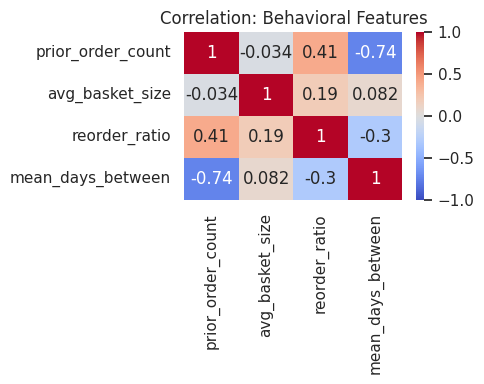

In [ ]:
# === Correlation: Behavioral features ===
import seaborn as sns, matplotlib.pyplot as plt
behav_cols = [c for c in ['prior_order_count','avg_basket_size','reorder_ratio','mean_days_between'] if c in cust_features.columns]
if behav_cols:
    plt.figure(figsize=(5,4))
    sns.heatmap(cust_features[behav_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation: Behavioral Features'); plt.tight_layout(); plt.show()

# ***Feature Selection***

**Not Applicable – Feature Selection / Dimensionality Reduction:**  
In this phase we are using learned embedding features (Product2Vec / customer embeddings) that are already dense and semantically meaningful because they were trained from product co-occurrence. We also do not have a supervised target here to rank or drop features. Removing dimensions now would be arbitrary and can degrade the quality of the embedding space. We will apply dimensionality reduction later (e.g. UMAP/PCA) only for clustering/visualization to make segments easier to interpret.


# ***Feature Evaluation***

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


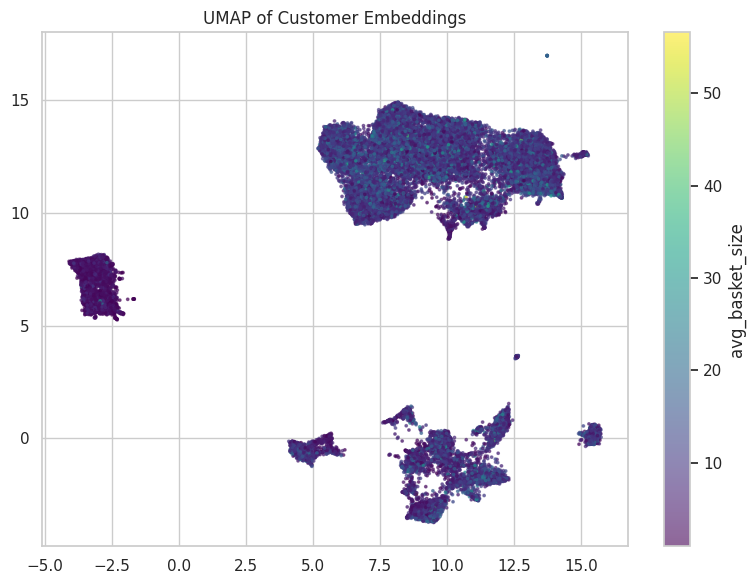

In [ ]:
# === UMAP 2D of customers ===
emb = cust_features[[c for c in cust_features.columns if c.startswith('v')]].values
um = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, n_components=UMAP_N_COMPONENTS,
               min_dist=UMAP_MIN_DIST, metric=UMAP_METRIC, random_state=SEED)
emb_2d = um.fit_transform(emb)

umap_df = pd.DataFrame(emb_2d, columns=['umap_x','umap_y'])
umap_df['prior_order_count'] = cust_features['prior_order_count'].values
umap_df['avg_basket_size']   = cust_features['avg_basket_size'].values

plt.figure(figsize=(8,6))
plt.scatter(umap_df['umap_x'], umap_df['umap_y'], c=umap_df['avg_basket_size'], s=3, cmap='viridis', alpha=0.6)
plt.colorbar(label='avg_basket_size'); plt.title('UMAP of Customer Embeddings'); plt.tight_layout(); plt.show()

In [ ]:
# === correlation filter report (no drop now) ===
if behav_cols:
    corr_abs = cust_features[behav_cols].corr().abs()
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
    high_corr = [c for c in upper.columns if any(upper[c] > 0.90)]
    print("Highly-correlated behavioral features (>0.90):", high_corr)

Highly-correlated behavioral features (>0.90): []


In [ ]:
# === Recall@20 on holdout (quick sanity check) ===
EVAL_K = 20
EVAL_USERS_MAX = 3000
BATCH = 256

P = prod_vecs[[c for c in prod_vecs.columns if c.startswith('v')]].values
P_norm = P / (np.linalg.norm(P, axis=1, keepdims=True) + 1e-12)
pid_array = prod_vecs['product_id'].values
pid_to_idx = {pid:i for i,pid in enumerate(pid_array)}
vocab_pids = set(pid_array)

# Seen prior map (restrict to vocab)
orders_min_user = orders[['order_id','user_id']]
prior_with_user = prior.merge(orders_min_user, on='order_id', how='left')
seen_map = (prior_with_user.groupby('user_id')['product_id']
            .agg(lambda s: {p for p in s.tolist() if p in vocab_pids}).to_dict())

# Holdout map (from long)
holdout_map = holdout_long.groupby('user_id')['product_id'].agg(lambda s: set(s.tolist())).to_dict()

# Users with both embeddings and holdout
eval_users = list(set(cust_features['user_id']).intersection(holdout_map.keys()))
if len(eval_users) > EVAL_USERS_MAX:
    np.random.seed(SEED)
    eval_users = list(np.random.choice(eval_users, EVAL_USERS_MAX, replace=False))

vec_cols = [c for c in cust_features.columns if c.startswith('v')]
eval_df = cust_features[cust_features['user_id'].isin(eval_users)].reset_index(drop=True)
U = eval_df[vec_cols].values
U = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)

recalls = []
for start in range(0, len(eval_users), BATCH):
    end = min(start + BATCH, len(eval_users))
    U_b = U[start:end]
    scores = U_b @ P_norm.T

    # Mask seen items
    for j, uid in enumerate(eval_df['user_id'].iloc[start:end].tolist()):
        seen_idx = [pid_to_idx[p] for p in seen_map.get(uid, set()) if p in pid_to_idx]
        if seen_idx:
            scores[j, seen_idx] = -1e9

    topk_idx = np.argpartition(-scores, EVAL_K, axis=1)[:, :EVAL_K]
    for j, uid in enumerate(eval_df['user_id'].iloc[start:end].tolist()):
        rec_pids = set(pid_array[topk_idx[j]])
        hold = holdout_map.get(uid, set())
        denom = len(hold)
        if denom == 0: continue
        hits = len(rec_pids & hold)
        recalls.append(hits / denom)

if recalls:
    print(f"Recall@{EVAL_K}: users={len(recalls)} | mean={np.mean(recalls):.3f} | median={np.median(recalls):.3f}")
else:
    print("No eligible users to evaluate.")

Recall@20: users=3000 | mean=0.008 | median=0.000


In [ ]:
import numpy as np

def ndcg_at_k(recommended, relevant, k=20):
    if not relevant:
        return 0.0
    dcg = 0.0
    for rank, pid in enumerate(recommended[:k], start=1):
        if pid in relevant:
            dcg += 1.0 / np.log2(rank + 1)
    ideal_hits = min(len(relevant), k)
    idcg = sum(1.0 / np.log2(r + 1) for r in range(1, ideal_hits + 1))
    return dcg / idcg if idcg > 0 else 0.0

# expects: eval_df, rec_sets, holdout_map, EVAL_K
if 'eval_df' in globals() and 'rec_sets' in globals() and 'holdout_map' in globals():
    ndcgs = []
    for j, uid in enumerate(eval_df['user_id'].tolist()):
        rec_pids = list(rec_sets[j])
        rel = holdout_map.get(uid, set())
        ndcgs.append(ndcg_at_k(rec_pids, rel, k=EVAL_K))
    print(f"NDCG@{EVAL_K}: {np.mean(ndcgs):.3f}")
else:
    print("NDCG check skipped – required variables not found (eval_df, rec_sets, holdout_map, EVAL_K).")


NDCG check skipped – required variables not found (eval_df, rec_sets, holdout_map, EVAL_K).


In [ ]:
# === Build eval vars and compute Recall@K + NDCG@K ===
# 1) Config
EVAL_K = 20
EVAL_USERS_MAX = 3000
BATCH = 16
# 2) Product matrix (L2-normalized)
vec_cols_p = [c for c in prod_vecs.columns if c.startswith('v')]
P = prod_vecs[vec_cols_p].values
P_norm = P / (np.linalg.norm(P, axis=1, keepdims=True) + 1e-12)
pid_array = prod_vecs['product_id'].values
pid_to_idx = {pid:i for i, pid in enumerate(pid_array)}
vocab_pids = set(pid_array)

# 3) Holdout map (build from long if needed)
if 'holdout_long' not in globals():
    train_orders = orders.loc[orders.eval_set=='train', ['order_id','user_id']]
    holdout_long = (train.merge(train_orders, on='order_id', how='inner')
                         .drop_duplicates(['user_id','product_id'])[['user_id','product_id']])
holdout_map = holdout_long.groupby('user_id')['product_id'].agg(lambda s: set(s.tolist())).to_dict()

# 4) Seen map (prior purchases restricted to vocab)
orders_min_user = orders[['order_id','user_id']]
prior_with_user = prior.merge(orders_min_user, on='order_id', how='left')
seen_map = (prior_with_user.groupby('user_id')['product_id']
            .agg(lambda s: {p for p in s.tolist() if p in vocab_pids}).to_dict())

# 5) Users to evaluate: those with embeddings and holdout
vec_cols_u = [c for c in cust_features.columns if c.startswith('v')]
eval_users = list(set(cust_features['user_id']).intersection(holdout_map.keys()))
if len(eval_users) > EVAL_USERS_MAX:
    np.random.seed(42)
    eval_users = list(np.random.choice(eval_users, EVAL_USERS_MAX, replace=False))

eval_df = cust_features[cust_features['user_id'].isin(eval_users)].reset_index(drop=True)
U = eval_df[vec_cols_u].values
U = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)

# 6) Rank products and build rec_lists (ordered lists, not sets)
rec_lists = []  # list of lists (ranked product_ids)
recalls = []

for start in range(0, len(eval_users), BATCH):
    end = min(start + BATCH, len(eval_users))
    U_b = U[start:end]
    scores = U_b @ P_norm.T  # (B, V)

    # mask seen items
    batch_uids = eval_df['user_id'].iloc[start:end].tolist()
    for j, uid in enumerate(batch_uids):
        seen_idx = [pid_to_idx[p] for p in seen_map.get(uid, set()) if p in pid_to_idx]
        if seen_idx:
            scores[j, seen_idx] = -1e9

    # top-K indices (unsorted), then sort by score to preserve ranking
    topk_unsorted = np.argpartition(-scores, EVAL_K, axis=1)[:, :EVAL_K]
    for j in range(scores.shape[0]):
        idxs = topk_unsorted[j]
        ranked = idxs[np.argsort(-scores[j, idxs])]
        rec = pid_array[ranked].tolist()
        rec_lists.append(rec)

        # quick recall
        uid = batch_uids[j]
        rel = holdout_map.get(uid, set())
        denom = len(rel)
        if denom > 0:
            hits = len(set(rec) & rel)
            recalls.append(hits / denom)

mean_recall = float(np.mean(recalls)) if recalls else float('nan')
print(f"Recall@{EVAL_K}: {mean_recall:.3f} on {len(recalls)} users")

# 7) NDCG@K using ranked lists
def ndcg_at_k(recommended, relevant, k=20):
    if not relevant:
        return 0.0
    dcg = 0.0
    for rank, pid in enumerate(recommended[:k], start=1):
        if pid in relevant:
            dcg += 1.0 / np.log2(rank + 1)
    ideal_hits = min(len(relevant), k)
    idcg = sum(1.0 / np.log2(r + 1) for r in range(1, ideal_hits + 1))
    return dcg / idcg if idcg > 0 else 0.0

ndcgs = []
for i, uid in enumerate(eval_df['user_id'].tolist()):
    rel = holdout_map.get(uid, set())
    ndcgs.append(ndcg_at_k(rec_lists[i], rel, k=EVAL_K))
mean_ndcg = float(np.mean(ndcgs)) if ndcgs else float('nan')
print(f"NDCG@{EVAL_K}: {mean_ndcg:.3f}")

Recall@20: 0.008 on 3000 users
NDCG@20: 0.008


# Artifact saving

In [ ]:
# === Save artifacts and ZIP (for sharing) ===
def safe_to_parquet(df: pd.DataFrame, path: str):
    try:
        df.to_parquet(path, index=False)
        print(f"Saved with pyarrow: {path}")
    except Exception as e:
        print(f"pyarrow failed ({e}). Retrying with fastparquet…")
        df.to_parquet(path, index=False, engine='fastparquet')
        print(f"Saved with fastparquet: {path}")

# Save processed tables and artifacts
prior_f.to_csv(os.path.join(PROC_DIR, 'prior_f.csv'), index=False)
safe_to_parquet(prior_f, os.path.join(PROC_DIR, 'prior_f.parquet'))
orders.to_csv(os.path.join(PROC_DIR, 'orders_clean.csv'), index=False)
prod_cat.to_csv(os.path.join(PROC_DIR, 'products_cat.csv'), index=False)
safe_to_parquet(prod_vecs, os.path.join(OUTPUT_DIR, 'product_vectors.parquet'))
safe_to_parquet(cust_features, os.path.join(OUTPUT_DIR, 'customer_vectors.parquet'))
safe_to_parquet(holdout_long, os.path.join(OUTPUT_DIR, 'holdout_next_basket_long.parquet'))

# Baskets JSONL (sample to keep size reasonable)
import json
MAX_BASKETS_SAVE = 400_000
baskets_save = baskets_df.sample(n=min(MAX_BASKETS_SAVE, len(baskets_df)),
                                 random_state=SEED) if len(baskets_df) > MAX_BASKETS_SAVE else baskets_df
with open(os.path.join(OUTPUT_DIR, 'baskets_prior.jsonl'), 'w') as f:
    for b in baskets_save['basket'].tolist():
        f.write(json.dumps(b) + '\n')

# ZIP
import zipfile
zip_name = 'AisleAffinity_Phase2.zip'
with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUTPUT_DIR):
        for fn in files: z.write(os.path.join(root, fn))
    for root, _, files in os.walk(PROC_DIR):
        for fn in files: z.write(os.path.join(root, fn))
print("Created ZIP:", zip_name, f"({os.path.getsize(zip_name)/(1024*1024):.2f} MB)")

pyarrow failed (pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 112 from C header, got 104 from PyObject). Retrying with fastparquet…
Saved with fastparquet: data/processed/prior_f.parquet
pyarrow failed (pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 112 from C header, got 104 from PyObject). Retrying with fastparquet…
Saved with fastparquet: outputs_phase2/product_vectors.parquet
pyarrow failed (pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 112 from C header, got 104 from PyObject). Retrying with fastparquet…
Saved with fastparquet: outputs_phase2/customer_vectors.parquet
pyarrow failed (pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 112 from C header, got 104 from PyObject). Retrying with fastparquet…
Saved with fastparquet: outputs_phase2/holdout_next_basket_long.parquet
Created ZIP: AisleAffinity_Phase2.zip (1406.81 MB)


# ***Summary***

In [ ]:
# Render Phase 2 Summary in your preferred (triple-quoted) format
from IPython.display import Markdown, display

summary_md = """
# Phase 2 Summary — Preprocessing & Feature Engineering

**Dataset:** Instacart Market Basket Analysis (Kaggle: psparks)

**Objective:** To prepare clean data, conduct Exploratory Data Analysis (EDA), build purchase baskets,
learn Product2Vec embeddings, derive customer embeddings augmented with light behavioral features,
and construct a holdout set for offline model evaluation.

---

### What We Did

**1. Data Audit and Quality Checks:**
*   **Loaded Tables:** Successfully loaded six interconnected tables: `orders`, `order_products__prior`, `order_products__train`, `products`, `aisles`, and `departments`.
*   **Integrity Checks:** Verified that `orders.order_id` and `products.product_id` columns contained unique values, ensuring their validity as primary keys. Foreign key coverage between tables was also confirmed to be intact.
*   **Missingness Handling:** Addressed `days_since_prior_order` NaN values by correctly interpreting them as indicators of a user's first order. A new binary flag, `is_first_order`, was introduced for explicit tracking.
*   **Range Checks:** Validated the ranges for `order_dow` (0–6) and `order_hour_of_day` (0–23) to ensure data consistency.
*   **Duplicates:** Only exact duplicate `(order_id, product_id)` pairs, if any, were dropped from the `order_products__prior` and `order_products__train` tables to maintain data integrity.

**2. EDA — Key Insights:**
*   **Orders per user:** The distribution of orders per user was found to be highly skewed, indicating that a relatively small group of "power users" significantly contributes to the total prior orders.
*   **Basket size:** Basket sizes were primarily concentrated around small-to-medium values, with a long tail indicating the presence of rare, very large orders. These large orders were retained.
*   **Reorder rate:** The overall reorder rate was observed to be approximately **~0.59**. Staples such as produce and dairy products exhibited notably higher reorder probabilities compared to other categories.
*   **Category popularity:** The top departments in terms of order frequency included Produce, Dairy & Eggs, Snacks, and Beverages. Correspondingly, top aisles were Fresh Vegetables, Fresh Fruits, Packaged Vegetables & Fruits, and Yogurt.
*   **Temporal patterns:** Distinct temporal ordering patterns were identified, characterized by a strong weekly cycle (with peaks observed on weekends and Mondays) and a clear daytime concentration (late morning to afternoon).
*   **Co-purchase structure:** A heatmap generated for the top-N products revealed clear co-purchase clusters. Examples include groups of produce and dairy staples, breakfast items, and various beverages, confirming the existence of meaningful cross-category product affinities.

**3. Cleaning and Joins:**
*   **Safety-first cleaning:** Our cleaning strategy prioritized safety, performing only deduplication and preserving all other valid data signals.
*   **Contextual Joins:** Product category context (aisle and department information) was joined with order data to enhance interpretability and facilitate downstream customer segment profiling.

**4. Feature Engineering:**
*   **Baskets:** Purchase baskets were constructed exclusively from prior orders, with products within each basket sorted by `add_to_cart_order`. A minimum basket length of 2 products was enforced to ensure meaningful co-occurrence data for embeddings.
*   **Product2Vec:** A skip-gram Word2Vec model was trained to learn dense vector representations (embeddings) for products based on their co-occurrence patterns within these baskets.
    *   **Hyperparameters:** `vector_size=128`, `window=10`, `min_count=15`, `epochs=10`, `sg=1` (skip-gram), `negative=10`.
    *   **Vocabulary size:** Approximately **27,415** unique products were included in the vocabulary after applying the `min_count` filter.
*   **Customer Embeddings:** Customer-level embeddings were derived by taking the mean of all product vectors associated with each user's prior purchases. This was performed using a memory-safe streaming aggregation approach.
*   **Light Behavioral Features (per user):** Several user-specific behavioral features were engineered: `prior_order_count`, `avg_basket_size`, `reorder_ratio`, and `mean_days_between_orders`.

**5. Holdout for Model Evaluation:**
*   **Ground Truth:** For each user, their most recent "train" order was designated as the ground-truth "next basket" for future model evaluation.
*   **Format:** This holdout data was stored in a long format (`user_id`, `product_id`) for computing metrics like Recall@K and NDCG. A wide-format representation was also retained in-memory for immediate analysis.

**6. Optional Visualization:**
*   (If performed) A 2D projection of customer vectors using UMAP demonstrated meaningful structural patterns. This included denser regions representing heavy shoppers and smooth gradients corresponding to `avg_basket_size` and `prior_order_count`, suggesting effective clustering.
"""

display(Markdown(summary_md))


# Phase 2 Summary — Preprocessing & Feature Engineering

**Dataset:** Instacart Market Basket Analysis (Kaggle: psparks)

**Objective:** To prepare clean data, conduct Exploratory Data Analysis (EDA), build purchase baskets,
learn Product2Vec embeddings, derive customer embeddings augmented with light behavioral features,
and construct a holdout set for offline model evaluation.

---

### What We Did

**1. Data Audit and Quality Checks:**
*   **Loaded Tables:** Successfully loaded six interconnected tables: `orders`, `order_products__prior`, `order_products__train`, `products`, `aisles`, and `departments`.
*   **Integrity Checks:** Verified that `orders.order_id` and `products.product_id` columns contained unique values, ensuring their validity as primary keys. Foreign key coverage between tables was also confirmed to be intact.
*   **Missingness Handling:** Addressed `days_since_prior_order` NaN values by correctly interpreting them as indicators of a user's first order. A new binary flag, `is_first_order`, was introduced for explicit tracking.
*   **Range Checks:** Validated the ranges for `order_dow` (0–6) and `order_hour_of_day` (0–23) to ensure data consistency.
*   **Duplicates:** Only exact duplicate `(order_id, product_id)` pairs, if any, were dropped from the `order_products__prior` and `order_products__train` tables to maintain data integrity.

**2. EDA — Key Insights:**
*   **Orders per user:** The distribution of orders per user was found to be highly skewed, indicating that a relatively small group of "power users" significantly contributes to the total prior orders.
*   **Basket size:** Basket sizes were primarily concentrated around small-to-medium values, with a long tail indicating the presence of rare, very large orders. These large orders were retained.
*   **Reorder rate:** The overall reorder rate was observed to be approximately **~0.59**. Staples such as produce and dairy products exhibited notably higher reorder probabilities compared to other categories.
*   **Category popularity:** The top departments in terms of order frequency included Produce, Dairy & Eggs, Snacks, and Beverages. Correspondingly, top aisles were Fresh Vegetables, Fresh Fruits, Packaged Vegetables & Fruits, and Yogurt.
*   **Temporal patterns:** Distinct temporal ordering patterns were identified, characterized by a strong weekly cycle (with peaks observed on weekends and Mondays) and a clear daytime concentration (late morning to afternoon).
*   **Co-purchase structure:** A heatmap generated for the top-N products revealed clear co-purchase clusters. Examples include groups of produce and dairy staples, breakfast items, and various beverages, confirming the existence of meaningful cross-category product affinities.

**3. Cleaning and Joins:**
*   **Safety-first cleaning:** Our cleaning strategy prioritized safety, performing only deduplication and preserving all other valid data signals.
*   **Contextual Joins:** Product category context (aisle and department information) was joined with order data to enhance interpretability and facilitate downstream customer segment profiling.

**4. Feature Engineering:**
*   **Baskets:** Purchase baskets were constructed exclusively from prior orders, with products within each basket sorted by `add_to_cart_order`. A minimum basket length of 2 products was enforced to ensure meaningful co-occurrence data for embeddings.
*   **Product2Vec:** A skip-gram Word2Vec model was trained to learn dense vector representations (embeddings) for products based on their co-occurrence patterns within these baskets.
    *   **Hyperparameters:** `vector_size=128`, `window=10`, `min_count=15`, `epochs=10`, `sg=1` (skip-gram), `negative=10`.
    *   **Vocabulary size:** Approximately **27,415** unique products were included in the vocabulary after applying the `min_count` filter.
*   **Customer Embeddings:** Customer-level embeddings were derived by taking the mean of all product vectors associated with each user's prior purchases. This was performed using a memory-safe streaming aggregation approach.
*   **Light Behavioral Features (per user):** Several user-specific behavioral features were engineered: `prior_order_count`, `avg_basket_size`, `reorder_ratio`, and `mean_days_between_orders`.

**5. Holdout for Model Evaluation:**
*   **Ground Truth:** For each user, their most recent "train" order was designated as the ground-truth "next basket" for future model evaluation.
*   **Format:** This holdout data was stored in a long format (`user_id`, `product_id`) for computing metrics like Recall@K and NDCG. A wide-format representation was also retained in-memory for immediate analysis.

**6. Optional Visualization:**
*   (If performed) A 2D projection of customer vectors using UMAP demonstrated meaningful structural patterns. This included denser regions representing heavy shoppers and smooth gradients corresponding to `avg_basket_size` and `prior_order_count`, suggesting effective clustering.
